In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
pip install pyvi

In [119]:
import os
import numpy as np
import pandas as pd

from gensim.models import Word2Vec, Phrases
from gensim.models.fasttext import FastText
from pyvi import ViTokenizer
from gensim.models.phrases import Phrases, Phraser

In [98]:
pathdata = '/content/drive/MyDrive/Data full/merged_data (2).txt'
stopwords_path = '/content/drive/MyDrive/Data full/stopwords.csv'

model_path = '/content/drive/MyDrive/Data full/word2vec.model'

In [99]:
# Đọc dữ liệu từ file
train_data = pd.read_csv(pathdata, delimiter='\t', header=None, names=['text'])
train_data['text_tokenized'] = train_data['text'].apply(ViTokenizer.tokenize)
train_data

,text,text_tokenized
0,Việt Nam quốc hiệu là Cộng hòa Xã hội chủ ngh...,Việt_Nam quốc_hiệu là Cộng_hòa Xã_hội chủ_nghĩ...
1,Lãnh thổ Việt Nam xuất hiện con người sinh sốn...,Lãnh_thổ Việt_Nam xuất_hiện con_người sinh_sốn...
2,Đến thời kỳ cận đại Việt Nam lần lượt trải qu...,Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải qua...
3,Sau khi thống nhất Việt Nam tiếp tục gặp khó ...,Sau khi thống_nhất Việt_Nam tiếp_tục gặp khó_k...
4,Tên gọi,Tên gọi
...,...,...
12232,Y học Gerhard Domagk,Y_học Gerhard_Domagk
12233,Văn học Frans Eemil Sillanpää,Văn_học Frans Eemil_Sillanpää
12234,Hòa bình không có giải,Hòa_bình không có giải
12235,Xem thêm,Xem thêm


In [100]:
# Đọc danh sách stopwords
stopwords_data = pd.read_csv(stopwords_path, sep="\t", encoding='utf-8')
stopwords_set = set(stopwords_data['stopwords'])
stopwords_data['stopwords'].head()

0      mà_thôi
1       tuy_có
2      đâu_như
3    quay_bước
4      hỏi_lại
Name: stopwords, dtype: object

In [101]:
# Tiền xử lý dữ liệu
train_data['text_cleaned'] = train_data['text_tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))
train_data['text_cleaned']

0        Việt_Nam quốc_hiệu Cộng_hòa Xã_hội chủ_nghĩa V...
1        Lãnh_thổ Việt_Nam con_người sinh_sống thời_đại...
2        Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải gia...
3        Sau thống_nhất Việt_Nam sụp_đổ tan_rã đồng_min...
4                                                  Tên gọi
                               ...                        
12232                                 Y_học Gerhard_Domagk
12233                        Văn_học Frans Eemil_Sillanpää
12234                                        Hòa_bình giải
12235                                                  Xem
12236                                            Tham_khảo
Name: text_cleaned, Length: 12237, dtype: object

In [102]:
# Chuyển dữ liệu huấn luyện thành danh sách các từ
sentences = [text.split() for text in train_data['text_cleaned']]

### Word2Vec Skip-gram

In [103]:
# Xử lý các cặp từ thông dụng hoặc cụm từ
bigram_transformer = Phraser(Phrases(sentences, min_count=5, threshold=100))
sentences_with_phrases = list(bigram_transformer[sentences])

# Xây dựng mô hình Word2Vec với Skip-gram
model_word2vec_skipgram = Word2Vec(sentences_with_phrases,
                                   vector_size=150,
                                   window=10,
                                   min_count=10,
                                   workers=4,
                                   sg=1,  # Sử dụng Skip-gram
                                   negative=5)
model_word2vec_skipgram.save(model_path)  # Lưu mô hình tại đường dẫn đã chỉ định

In [104]:
# Lấy số lượng từ trong từ vựng
total_words_skipgram = len(model_word2vec_skipgram.wv.key_to_index)
total_words_skipgram

1499

In [105]:
model_size_skipgram = model_word2vec_skipgram.estimate_memory()
model_size_skipgram

{'vocab': 749500, 'vectors': 899400, 'syn1neg': 899400, 'total': 2548300}

In [106]:
# Hiển thị từ có độ tương đồng cao nhất
for word, score in model_word2vec_skipgram.wv.most_similar("Hồ_Chí_Minh"):
    print(word, score)

Cộng_sản 0.9746757745742798
Nguyễn_Ái_Quốc 0.9611116647720337
Đảng 0.9587249159812927
Hội 0.9585098028182983
Cộng_sản_Việt_Nam 0.9570621252059937
cách_mạng 0.9565807580947876
nhân_dân 0.9523436427116394
Ông 0.9507482647895813
Trung_ương_Đảng 0.9445655345916748
Đại_hội 0.9401604533195496


In [107]:
# Tính toán khoảng cách giữa hai từ
word1 = "máy_tính"
word2 = "Độc_lập"
distance = model_word2vec_skipgram.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'máy_tính' và 'Độc_lập': 0.2987360954284668


In [108]:
#Trích xuất vectơ word embedding của một từ
word = "máy_tính"
embedding_vector = model_word2vec_skipgram.wv.get_vector(word)
print(f"Vectơ word embedding của '{word}': {embedding_vector}")

Vectơ word embedding của 'máy_tính': [ 9.21414979e-03 -2.37077903e-02  7.19805807e-02  6.99053556e-02
 -1.78434238e-01 -1.39620617e-01  7.33235255e-02  1.08304478e-01
  8.16523582e-02  1.05543055e-01  1.72309682e-01 -1.16241492e-01
 -6.59053028e-02  7.67557397e-02  1.36096282e-02 -7.76444972e-02
  1.58637494e-01 -2.38246158e-01 -4.20535952e-02  2.71192454e-02
 -1.30783856e-01 -6.57908916e-02 -9.85120013e-02 -9.40749794e-02
  2.55292300e-02  1.18832299e-02 -2.15396777e-01 -1.30772963e-01
 -9.83203501e-02 -2.82257907e-02  1.42870858e-01  1.76632181e-01
  3.73144448e-02  1.22488954e-03 -2.12360874e-01 -2.14468483e-02
  9.19374749e-02  5.10174595e-03 -2.64263283e-02 -7.85869956e-02
  3.80759202e-02  6.04614094e-02 -1.95041802e-02 -6.19242154e-02
  7.14413375e-02  4.60656397e-02 -1.95198227e-03  2.05068365e-01
  1.38495630e-02  3.46098617e-02 -2.29503959e-02 -7.58134648e-02
 -2.15726048e-01  4.75451797e-02 -1.64538417e-02  1.48482218e-01
 -6.61102589e-03  1.39744341e-01 -1.23194642e-01  7.1

### Word2Vec CBOW

In [110]:
# Xử lý các cặp từ thông dụng hoặc cụm từ
bigram_transformer = Phraser(Phrases(sentences, min_count=5, threshold=100))
sentences_with_phrases = list(bigram_transformer[sentences])

In [111]:
# Xây dựng mô hình Word2Vec với CBOW
model_word2vec_cbow = Word2Vec(sentences_with_phrases,
                               vector_size=150,
                               window=10,
                               min_count=10,
                               workers=4,
                               sg=0,  # Sử dụng CBOW
                               negative=5)
model_word2vec_cbow.save(model_path)  # Lưu mô hình tại đường dẫn đã chỉ định

In [112]:
# Hiển thị từ có độ tương đồng cao nhất
for word, score in model_word2vec_cbow.wv.most_similar("Hồ_Chí_Minh"):
    print(word, score)

Việt_Nam 0.9995889067649841
Đảng 0.9974742531776428
tổ_chức 0.9972620010375977
dân_tộc 0.9970619082450867
chủ_nghĩa 0.9963573813438416
gọi 0.9961419701576233
đi 0.9960340857505798
dân 0.9959524869918823
miền_Nam 0.9959455728530884
Trung_Quốc 0.9957913756370544


In [113]:
similar_words = model_word2vec_skipgram.wv.most_similar("Ủy_ban")

In [114]:
# Tính toán khoảng cách giữa hai từ
word1 = "máy_tính"
word2 = "Độc_lập"
distance = model_word2vec_cbow.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'máy_tính' và 'Độc_lập': 0.0029338598251342773


In [115]:
# Tính toán khoảng cách giữa hai từ
word1 = "Nhân_dân"
word2 = "Hoa_hậu"
distance = model_word2vec_cbow.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'Nhân_dân' và 'Hoa_hậu': 0.001848757266998291


In [116]:
#Trích xuất vectơ word embedding của một từ
word = "máy_tính"
embedding_vector = model_word2vec_cbow.wv.get_vector(word)
print(f"Vectơ word embedding của '{word}': {embedding_vector}")

Vectơ word embedding của 'máy_tính': [ 7.22764283e-02 -6.81587234e-02 -5.91510758e-02  3.05388179e-02
 -7.15376437e-02 -4.40696850e-02  3.11464481e-02  8.40661824e-02
  2.94721592e-02  4.07634825e-02  7.99230710e-02 -8.47586468e-02
 -1.00372814e-01  3.55120152e-02 -5.36443219e-02 -3.90931182e-02
  9.60518047e-02 -1.04159862e-01  1.77478958e-02  5.64837456e-02
 -1.03183381e-01 -7.65839815e-02  2.54019629e-02 -5.69133759e-02
  5.88255450e-02  3.75982635e-02 -2.08237007e-01 -1.00474589e-01
  1.33413747e-02 -1.03509039e-01  4.36312854e-02  1.04948305e-01
 -6.54627290e-03 -4.25304063e-02 -8.58521909e-02  4.00039367e-02
  1.37923449e-01  1.08353170e-02  2.69777402e-02 -2.90709976e-02
  1.23108961e-02  3.84281878e-03 -3.18828784e-02 -2.71406565e-02
  7.34863207e-02 -7.83002353e-04  2.27593798e-02  7.30760098e-02
 -2.72696242e-02  9.64274034e-02 -5.75079061e-02 -3.88665148e-03
 -9.08301845e-02  9.73756090e-02 -2.79374793e-02  1.00106135e-01
  1.70490295e-02  7.37249106e-02 -8.15154836e-02  7.2

In [120]:
def text_to_vector(text):
    words = text.split()
    word_vectors = [model_word2vec_skipgram.wv[word] for word in words if word in model_word2vec_skipgram.wv]
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
        return text_vector
    return None

text = "Đây là một ví dụ về việc biểu diễn văn bản thành vectơ word embedding."
vector = text_to_vector(text)
print(vector)


[ 0.0667848   0.04835515  0.02356707  0.03906149 -0.08103332 -0.08149151
  0.13780254  0.02312153  0.1368707   0.11594494  0.20217371 -0.1029715
 -0.07466764  0.00420736 -0.01230151 -0.04544871  0.19280457 -0.20543839
  0.09704439  0.04379777 -0.09912652 -0.04161289 -0.00045021 -0.30591378
  0.16810878  0.03712108 -0.2774061  -0.2048796   0.14280719  0.11594957
  0.2756417   0.19159462 -0.10538628  0.16450305 -0.17825226  0.01416332
 -0.03075543 -0.05115775 -0.03463442  0.0403084  -0.06821755  0.03887682
  0.08957853  0.00899635  0.00948961  0.00222909  0.1291119   0.16230942
 -0.04815838  0.03730586  0.02087006 -0.02437323 -0.2527692   0.02324831
 -0.06395498  0.17836146  0.00858674  0.12048477 -0.16132955  0.03454606
  0.03733915 -0.02920771 -0.04046715  0.05973108 -0.04190243  0.02263413
  0.00463312 -0.08933558 -0.04207147 -0.06136133  0.03603207 -0.04750417
  0.06965746  0.05769327 -0.35400835 -0.07668274  0.01166026  0.2014376
 -0.25876725  0.19433947 -0.04073426 -0.15681566  0.0

###Mở rộng từ vựng mô hình với dữ liệu mới:

In [122]:
# Đọc dữ liệu mới
new_data = pd.read_csv('/content/drive/MyDrive/Data full/Data_WE/data_new.txt', delimiter='\t', header=None, names=['text'])
new_data['text_tokenized'] = new_data['text'].apply(ViTokenizer.tokenize)

# Tiền xử lý dữ liệu mới
new_data['text_cleaned'] = new_data['text_tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))

# Chuyển dữ liệu mới thành danh sách các từ
new_sentences = [text.split() for text in new_data['text_cleaned']]

# Mở rộng từ vựng hiện có với dữ liệu mới
model_word2vec_skipgram.build_vocab(new_sentences, update=True)
model_word2vec_cbow.build_vocab(new_sentences, update=True)

# Huấn luyện lại mô hình với dữ liệu mới
model_word2vec_skipgram.train(new_sentences, total_examples=model_word2vec_skipgram.corpus_count, epochs=model_word2vec_skipgram.epochs)
model_word2vec_cbow.train(new_sentences, total_examples=model_word2vec_cbow.corpus_count, epochs=model_word2vec_cbow.epochs)

# Lưu mô hình đã được mở rộng từ vựng
model_word2vec_skipgram.save('/content/drive/MyDrive/Data full/word2vec_skipgram_extended.model')
model_word2vec_cbow.save('/content/drive/MyDrive/Data full/word2vec_cbow_extended.model')

In [123]:
# Lấy số lượng từ trong từ vựng
total_words_skipgram = len(model_word2vec_skipgram.wv.key_to_index)
total_words_skipgram

2545

### biểu đồ được tạo từ mô hình Word2Vec skip-gram

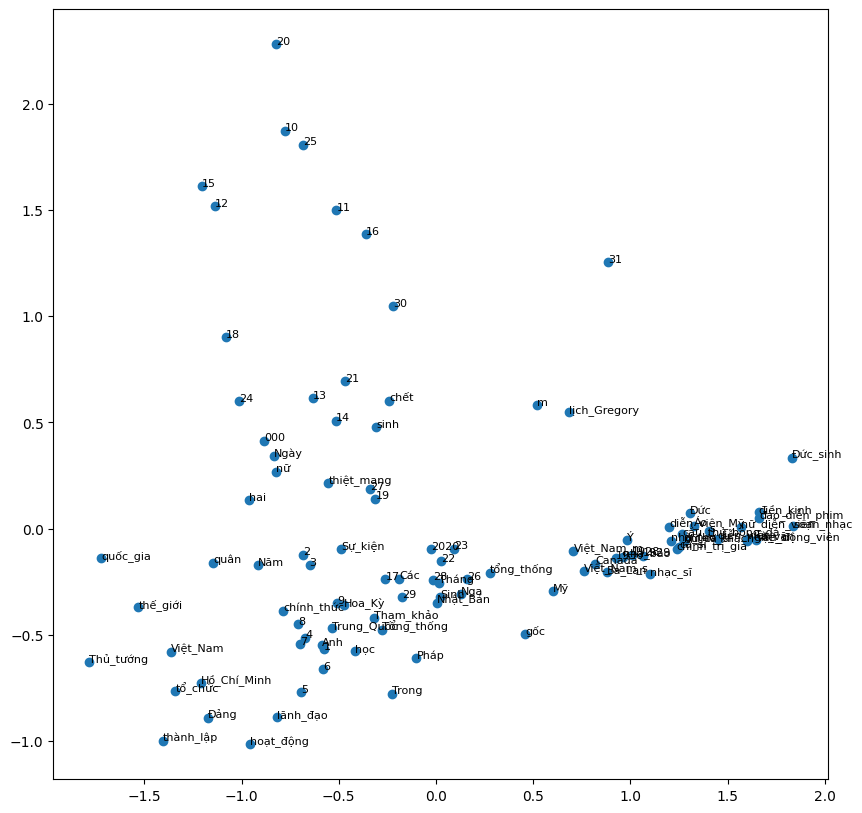

In [138]:
import matplotlib.pyplot as plt

# Lấy danh sách các từ trong từ vựng
vocab_words_skipgram = list(model_word2vec_skipgram.wv.index_to_key)

# Lấy vectơ word embedding cho một số từ
word_vectors_skipgram = [model_word2vec_skipgram.wv[word] for word in vocab_words_skipgram[:100]]

# Thực hiện phân tích giảm chiều dữ liệu để biểu diễn các vectơ word embedding trong không gian 2D
from sklearn.decomposition import PCA
pca_skipgram = PCA(n_components=2)
word_vectors_2d_skipgram = pca_skipgram.fit_transform(word_vectors_skipgram)

# Tạo biểu đồ từ
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d_skipgram[:, 0], word_vectors_2d_skipgram[:, 1])

# Gán nhãn cho từng điểm trên biểu đồ
for i, word in enumerate(vocab_words_skipgram[:100]):
    plt.annotate(word, xy=(word_vectors_2d_skipgram[i, 0], word_vectors_2d_skipgram[i, 1]), fontsize=8)

# Hiển thị biểu đồ
plt.show()